In [1]:
from pathlib import Path
import os


current_path = Path.cwd()

while not (current_path / "data").exists() and current_path != current_path.parent:
    current_path = current_path.parent

os.chdir(current_path)
print("Working directory set to:", Path.cwd())

# block ensures that notebook always runs from the project root directory.


Working directory set to: /Users/richardlesko/Desktop/Data Processing in Python/GitHub - Natural Gas/Python-Final-Project-Natural-gas-price-analysis-


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

project_root = Path.cwd()

for _ in range(5):
    if (project_root / ".git").exists():
        break
    project_root = project_root.parent

raw_data_path = project_root / "data" / "raw" / "eia_henryhub_weekly_raw.csv"
processed_data_dir = project_root / "data" / "processed"

processed_data_dir.mkdir(parents=True, exist_ok=True)

raw_data_path, processed_data_dir

#project root and data paths set up correctly so it can work with any notebook.



(PosixPath('/Users/richardlesko/Desktop/Data Processing in Python/GitHub - Natural Gas/Python-Final-Project-Natural-gas-price-analysis-/data/raw/eia_henryhub_weekly_raw.csv'),
 PosixPath('/Users/richardlesko/Desktop/Data Processing in Python/GitHub - Natural Gas/Python-Final-Project-Natural-gas-price-analysis-/data/processed'))

In [3]:
weekly_raw_df = pd.read_csv(raw_data_path)

print("Dataset shape:", weekly_raw_df.shape)

display(weekly_raw_df.head(10))

print("Column names:", weekly_raw_df.columns.tolist())

#make sure data is loaded correctly and inspect the first few rows


Dataset shape: (1814, 6)


,week_of,mon,tue,wed,thu,fri
0,1997 Jan- 6 to Jan-10,NaN,3.82,3.80,3.61,3.92
1,1997 Jan-13 to Jan-17,4.00,4.01,4.34,4.71,3.91
2,1997 Jan-20 to Jan-24,3.26,2.99,3.05,2.96,2.62
3,1997 Jan-27 to Jan-31,2.98,3.05,2.91,2.86,2.77
4,1997 Feb- 3 to Feb- 7,2.49,2.59,2.65,2.51,2.39
5,NaN,NaN,NaN,NaN,NaN,NaN
6,1997 Feb-10 to Feb-14,2.42,2.34,2.42,2.22,2.12
7,1997 Feb-17 to Feb-21,NaN,1.84,1.95,1.92,1.92
8,1997 Feb-24 to Feb-28,1.92,1.77,1.81,1.80,1.78
9,1997 Mar- 3 to Mar- 7,1.80,1.87,1.92,1.82,1.89


Column names: ['week_of', 'mon', 'tue', 'wed', 'thu', 'fri']


In [4]:
weekly_raw_df.columns = [col.strip().lower() for col in weekly_raw_df.columns]

weekly_raw_df = weekly_raw_df.dropna(subset=["week_of"]).copy()

weekly_raw_df["week_of"] = weekly_raw_df["week_of"].astype(str).str.strip()

display(weekly_raw_df.head())
print("Dataset shape after cleaning:", weekly_raw_df.shape)

# Clean column names and handle missing values in 'week_of' column.

,week_of,mon,tue,wed,thu,fri
0,1997 Jan- 6 to Jan-10,NaN,3.82,3.80,3.61,3.92
1,1997 Jan-13 to Jan-17,4.00,4.01,4.34,4.71,3.91
2,1997 Jan-20 to Jan-24,3.26,2.99,3.05,2.96,2.62
3,1997 Jan-27 to Jan-31,2.98,3.05,2.91,2.86,2.77
4,1997 Feb- 3 to Feb- 7,2.49,2.59,2.65,2.51,2.39


Dataset shape after cleaning: (1512, 6)


In [5]:
def parse_week_start(s: str):
    """
    EIA weekly 'week_of' looks like:
    '1997 Jan- 6 to Jan-10' or '1997 Feb-10 to Feb-14'
    We extract the YEAR + first month token + first day number.
    """
    s = str(s)

    m_year = re.search(r"(\d{4})", s)
    if not m_year:
        return pd.NaT
    year = int(m_year.group(1))

    m_mon = re.search(r"\b(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\b", s)
    if not m_mon:
        return pd.NaT
    mon = m_mon.group(1)

    m_day = re.search(rf"{mon}\s*-\s*(\d{{1,2}})", s)
    if not m_day:
        return pd.NaT
    day = int(m_day.group(1))

    return pd.to_datetime(f"{year} {mon} {day}", format="%Y %b %d", errors="coerce")

dfw["week_start"] = dfw["week_of"].apply(parse_week_start)

for c in ["mon", "tue", "wed", "thu", "fri"]:
    if c in dfw.columns:
        dfw[c] = pd.to_numeric(dfw[c], errors="coerce")

display(dfw[["week_of","week_start","mon","tue","wed","thu","fri"]].head(10))
print("Missing week_start:", dfw["week_start"].isna().sum())


NameError: name 'dfw' is not defined

In [ ]:
daily = dfw.melt(
    id_vars=["week_of", "week_start"],
    value_vars=["mon", "tue", "wed", "thu", "fri"],
    var_name="dow",
    value_name="price_usd_per_mmbtu"
)

dow_to_offset = {"mon": 0, "tue": 1, "wed": 2, "thu": 3, "fri": 4}
daily["date"] = daily["week_start"] + pd.to_timedelta(daily["dow"].map(dow_to_offset), unit="D")

daily = daily.dropna(subset=["date"]).copy()
daily = daily.sort_values("date")

daily = daily.dropna(subset=["price_usd_per_mmbtu"]).copy()

daily = daily[["date", "price_usd_per_mmbtu", "dow", "week_of"]].reset_index(drop=True)

display(daily.head(10))
print("Rows:", daily.shape[0], "| Date range:", daily["date"].min(), "to", daily["date"].max())

# what we did here is transform weekly data into daily data by melting 
# the DataFrame and calculating exact dates for each day of the week. 
# We also cleaned the data by removing rows with missing dates or prices.

,date,price_usd_per_mmbtu,dow,week_of
0,1997-01-07,3.82,tue,1997 Jan- 6 to Jan-10
1,1997-01-08,3.80,wed,1997 Jan- 6 to Jan-10
2,1997-01-09,3.61,thu,1997 Jan- 6 to Jan-10
3,1997-01-10,3.92,fri,1997 Jan- 6 to Jan-10
4,1997-01-13,4.00,mon,1997 Jan-13 to Jan-17
5,1997-01-14,4.01,tue,1997 Jan-13 to Jan-17
6,1997-01-15,4.34,wed,1997 Jan-13 to Jan-17
7,1997-01-16,4.71,thu,1997 Jan-13 to Jan-17
8,1997-01-17,3.91,fri,1997 Jan-13 to Jan-17
9,1997-01-20,3.26,mon,1997 Jan-20 to Jan-24


Rows: 7278 | Date range: 1997-01-07 00:00:00 to 2025-12-29 00:00:00


In [ ]:
dupes = daily.duplicated(subset=["date"]).sum()
print("Duplicate dates:", dupes)

bday = pd.date_range(daily["date"].min(), daily["date"].max(), freq="B")
missing = set(bday.date) - set(daily["date"].dt.date)
print("Missing business days (rough count):", len(missing))

print(daily["price_usd_per_mmbtu"].describe())

#check for duplicates and missing business days like holidays in mind 


Duplicate dates: 0
Missing business days (rough count): 282
count    7278.000000
mean        4.084929
std         2.150137
min         1.050000
25%         2.600000
50%         3.390000
75%         5.050000
max        23.860000
Name: price_usd_per_mmbtu, dtype: float64


In [ ]:
out_daily = OUT_DIR / "henryhub_daily.csv"
out_weekly_clean = OUT_DIR / "henryhub_weekly_clean.csv"

daily.to_csv(out_daily, index=False)
dfw.to_csv(out_weekly_clean, index=False)

print("Saved:", out_daily)
print("Saved:", out_weekly_clean)


Saved: c:\Users\gefer\OneDrive - Univerzita Karlova\Natural Gas python\Final Project\Python-Final-Project-Natural-gas-price-analysis-\data\processed\henryhub_daily.csv
Saved: c:\Users\gefer\OneDrive - Univerzita Karlova\Natural Gas python\Final Project\Python-Final-Project-Natural-gas-price-analysis-\data\processed\henryhub_weekly_clean.csv


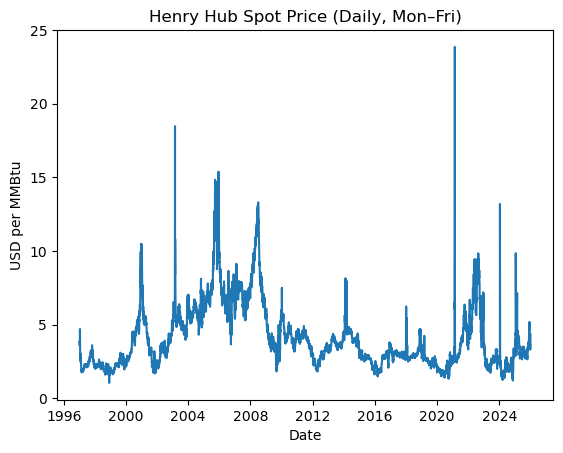

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(daily["date"], daily["price_usd_per_mmbtu"])
plt.title("Henry Hub Spot Price (Daily, Mon–Fri)")
plt.xlabel("Date")
plt.ylabel("USD per MMBtu")
plt.show()


In [ ]:
#we use friday close as the weekly price

weekly = (
    daily
    .sort_values("date")
    .groupby(pd.Grouper(key="date", freq="W-FRI"))
    .agg(price=("price_usd_per_mmbtu", "last"))
    .dropna()
    .reset_index()
)

weekly.head()


,date,price
0,1997-01-10,3.92
1,1997-01-17,3.91
2,1997-01-24,2.62
3,1997-01-31,2.77
4,1997-02-07,2.39


In [ ]:
weekly["log_return"] = np.log(weekly["price"]).diff()
weekly = weekly.dropna().reset_index(drop=True)

weekly.head()


,date,price,log_return
0,1997-01-17,3.91,-0.002554
1,1997-01-24,2.62,-0.400363
2,1997-01-31,2.77,0.055673
3,1997-02-07,2.39,-0.147554
4,1997-02-14,2.12,-0.119877


In [ ]:
out_weekly = OUT_DIR / "henryhub_weekly_returns.csv"
weekly.to_csv(out_weekly, index=False)
out_weekly
#(should be our DEPENDEDNT VARIABLE )

WindowsPath('c:/Users/gefer/OneDrive - Univerzita Karlova/Natural Gas python/Final Project/Python-Final-Project-Natural-gas-price-analysis-/data/processed/henryhub_weekly_returns.csv')